# Attention Is All You Need

In 2017 the Transformer was released and it is solely dependant on attention. In this tutorial, we will:
1. Go through the paper
2. Code through the different layers

Paper: [Attention Is All You need](https://arxiv.org/abs/1706.03762)

Before transformers, recurrent architectures used feedback loops to pass information step by step. The encoder's final hidden state had to compress the entire input sequence into one vector, no matter how long. Information inevitably got lost in that compression. The transformer with its attention mechanism solved this bottleneck by letting the model look at all positions directly.


## Model Architecture


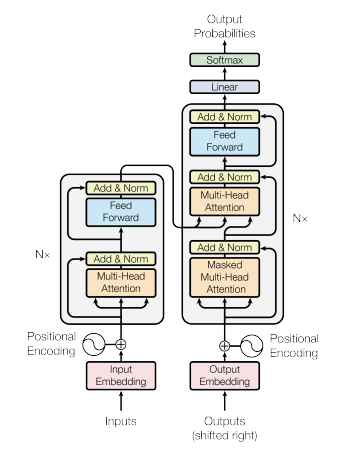

(Source: Attention Is All You Need paper)

The transformer is based on the encoder-decoder architecture. The encoder converts the input sequence of tokens into a sequence of embedding vectors called hidden states. The decoder uses these hidden states to generate output.


### Encoder
The encoder has 6 identical layers stacked together, each layer has 2 sublayers:
1. Multi-head self-attention mechanism
2. Fully connected feed-forward network

There is a **residual connection** around each of the two sublayers i.e. add the original input to the output to mitigate the vanishing gradients problem. About half of the cases, the gradient is zero when using ReLU. Without the. residual connections, a large part of the training signal is lost during back propagation. This is then followed by **layer of normalisation**.


### Decoder
The decoder has a stack of 6 identical layers with the same sublayers as the encoder plus a sublayer that performs multihead attention over the output of the encoder stack. It also has residual connections followed by a normalisation layer as in the encoder. Masking is used so that the predictions for position i can depend only on the known outputs at positions less than i

## Attention Mechanism

Imagine having to focus on every single detail in a story at once, this would be too much information. That's why there is attention. We get to focus on the important information depending on the context. The same applies to models.  relevant parts while filtering out the noise. The decoder assigns a different amount of weight to each of the encoder's states at each step

### Scaled Dot Product Attention

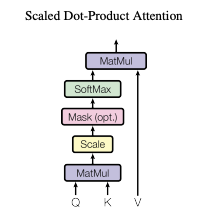

(Source: Attention Is All You Need paper)

For Scaled Dot-Product Attention, we compute a dot product of the query with all keys and divide by square root of dk. A softmax function is then applied to obtain the weights on the values. The equation is as below:

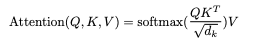

Adds a scaling factor to the dot product attention to counter vvanishing gradients
Masking
- Later words not influencing later words
- later tokens set to -infinity

In [ ]:
import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [1]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self):
    super(ScaledDotProductAttention, self).__init__()

  def forward(self, q, k, v, mask):
    d_k = k.size(-1)
    logits = torch.matmul(q, k.transpose(-2, -1))/ math.sqrt(d_k)

    if mask is not None:
      logits = logits.masked_fill(mask == 0, float('-inf'))

    attention = F.softmax(logits, dim=-1)
    output = torch.matmul(attention, v)
    return output

### Multi-Head Attention
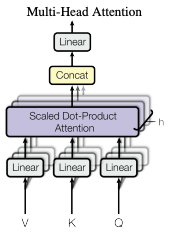

Instead of performing a single attention function, the keys,values and queries are projected h times with different learned linear projections to dk, dk and dv. Multi head attention allows the model to learn from different representation subspaces


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, d_model, dropout=0.1):
    super(MultiHeadAttention, self).__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    assert d_model % n_heads == 0

    self.dropout= dropout

    #linear projections in features , out features
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

    self.attention = ScaledDotProductAttention()

  def split_heads(self, x, n_heads):
    batch_size, seq_len, hidden_dim = x.size()
    x = x.view(batch_size, seq_len, n_heads, hidden_dim//n_heads)

    return x.transpose(1,2)

  def combine_heads(self, x):
    batch_size, n_heads, seq_len, head_dim = x.size()
    return x.transpose(1,2).contiguous().view(batch_size, seq_len, n_heads * head_dim)

  def forward(self, q, k, v, mask=None):

    q = self.w_q(q)
    k = self.w_k(k)
    v = self.w_v(v)

    #split to heads: batch size, seq len, num heads, head dim
    q = self.split_heads(q, self.n_heads)
    k = self.split_heads(k, self.n_heads)
    v = self.split_heads(v, self.n_heads)

    #scaled dot product attention
    output = self.attention(q, k, v, mask)

    # Concatenate heads and apply final linear layer
    output = self.combine_heads(output)
    output = self.w_o(output)
    return output

## Feed Forward Neural network

This is applied after the attention layer. It consists of two linear transformations with a ReLU activation between them. The formula is as below:

Screenshot 2026-01-13 at 18.19.37.png



In [ ]:
class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(FeedForwardNeuralNetwork, self).__init__()
    self.d_model = d_model
    self.d_ff = d_ff
    self.dropout = dropout

    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)

    self.dropout_layer = nn.Dropout(dropout)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout_layer(x)
    x = self.linear2(x)
    return x

## Positional Encoding

Adds information about the position of each token in the sequence to the input embeddings

Why? Helps understand the position of tokens and to differentiate between words in different psoitions and capturing structure of a sentence


In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000, dropout=0.1):
    super(PositionalEncoding, self).__init__()

    self.d_model = d_model
    self.max_len = max_len
    self.dropout = dropout

    self.dropout_layer = nn.Dropout(dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, :x.size(1), :]
    #return self.dropout_layer(x)
    return x

## Encoder Block

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
    super(EncoderLayer, self).__init__()

    self.d_model=d_model
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.dropout=dropout

    #multihead attention
    self.attention_layer = MultiHeadAttention(n_heads, d_model, dropout)
    self.layer_norm1 = nn.LayerNorm(d_model, eps=1e-6)

    #feed forward neural network
    self.ff_layer = FeedForwardNeuralNetwork(d_model, d_ff, dropout)
    self.layer_norm2 = nn.LayerNorm(d_model, eps=1e-6)

    self.dropout_layer = nn.Dropout(dropout)

  def forward(self, x, mask=None):
    attn_output = self.attention_layer(x,x,x, mask)
    x = self.layer_norm1(x + self.dropout_layer(attn_output))

    ff_output = self.ff_layer(x)
    x = self.layer_norm2(x + self.dropout_layer(ff_output))
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self,vocab_size, d_model, n_layers,n_heads, d_ff, pad_idx, dropout=0.1, max_len=5000):
    super(Encoder, self).__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.n_heads = n_heads
    self.d_ff = d_ff
    self.pad_idx = pad_idx
    self.dropout = dropout
    self.max_len = max_len

    self.embedding_layer = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)

    self.positional_encoding = PositionalEncoding(d_model, max_len,dropout)

    self.layers = nn.ModuleList([
        EncoderLayer(d_model, n_heads, d_ff, dropout)
        for _ in range(n_layers)
        ])

    self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

  def forward(self, x, mask=None):
    x = self.embedding_layer(x)
    x = self.positional_encoding(x)

    for layer in self.layers:
      x = layer(x, mask)

    x = self.layer_norm(x)

    return x


## Decoder Block

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
    super(DecoderLayer, self).__init__()

    self.d_model=d_model
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.dropout=dropout

    #multihead attention
    self.attention_layer = MultiHeadAttention(n_heads, d_model, dropout)
    self.layer_norm1 = nn.LayerNorm(d_model, eps=1e-6)

    self.encoder_attention_layer = MultiHeadAttention(n_heads, d_model, dropout)
    self.layer_norm2 = nn.LayerNorm(d_model, eps=1e-6)

    #feed forward neural network
    self.ff_layer = FeedForwardNeuralNetwork(d_model, d_ff, dropout)
    self.layer_norm3 = nn.LayerNorm(d_model, eps=1e-6)

    self.dropout_layer = nn.Dropout(dropout)

  def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
    attn_output = self.attention_layer(x,x,x, tgt_mask)
    x = self.layer_norm1(x + self.dropout_layer(attn_output))

    attn_output = self.encoder_attention_layer(x,encoder_output,encoder_output,src_mask)
    x = self.layer_norm2(x + self.dropout_layer(attn_output))

    ff_output = self.ff_layer(x)
    x = self.layer_norm3(x + self.dropout_layer(ff_output))
    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self,vocab_size, d_model, n_layers,n_heads, d_ff, pad_idx, dropout=0.1, max_len=5000):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.n_heads = n_heads
    self.d_ff = d_ff
    self.pad_idx = pad_idx
    self.dropout = dropout
    self.max_len = max_len

    self.embedding_layer = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)

    self.positional_encoding = PositionalEncoding(d_model, max_len,dropout)

    self.layers = nn.ModuleList([
        DecoderLayer(d_model, n_heads, d_ff, dropout)
        for _ in range(n_layers)
        ])

    self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

  def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
    x = self.embedding_layer(x)
    x = self.positional_encoding(x)

    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)

    x = self.layer_norm(x)

    return x


## Transformer Architecture

In [ ]:
class Transformer(nn.Module):
  def __init__(self,vocab_size, d_model=512, n_layers=6,n_heads=8, d_ff=2048, dropout=0.1, max_len=5000):
      super(Transformer, self).__init__()
      self.encoder = Encoder(vocab_size,d_model, n_layers, n_heads,d_ff, pad_idx=0, dropout=0.1, max_len=5000)
      self.decoder = Decoder(vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx=0, dropout=0.1, max_len=5000)
      self.linear = nn.Linear(d_model, vocab_size)

  def forward(self, src, tgt, src_mask=None, tgt_mask=None):
      encoder_output = self.encoder(src, src_mask)
      decoder_output = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
      output = self.linear(decoder_output)
      #output = F.softmax(output, dim=-1)
      return output
